# Project 2 - 80s Movie Data

In [1]:
from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
import requests
import re
from datetime import datetime
import pickle

from IPython.core.display import display, HTML
import pandas as pd
import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
from imdb_big_scrape import get_movie_links
from getting_info import get_movie_data
from sklearn.linear_model import LinearRegression
%load_ext autoreload
%autoreload 2

## Import necessary packages

## Step 1: Collect links using the 'get_movie_links' function
This function gathers data from IMDb using BeautifulSoup. Specifically, the function focuses on movies between 2018 and 2020 to be accurate prediting in the near future. There are over 20,000 results in the seach, which is plenty of information to acquire. The input to the function is how many pages is desired to scrape. Each page holds 100 movies. The function is liable to take some time, so I like the option to scrape less pages if desired.

In [2]:
movie_links = get_movie_links(80,1)
# Collect movie links
# 5  -->  500 links
# 10 --> 1000 links
# 20 --> 2000 links
# 40 --> 4000 links

In [8]:
len(movie_links[4300:])

3700

## Step 2: Use the 'get_movie_data' function to collect desired data
This function also uses BeautifulSoup and takes the links collected using the get_movie_links function to return a list full of dictionaries holding information for each link passed into the function. After collecting the data, it's very easy to pass this into a Pandas DataFrame.

In [9]:
count = 0
movie_data_list = []
for link in movie_links[4300:]:
    movie_data_list.append(get_movie_data(link))
    count += 1
    if count % 50 == 0:
        with open('IMDb_big_list.pickle2', 'wb') as to_write:
            pickle.dump(movie_data_list, to_write)
# Create list with all movies from movie links
to_write.close()

In [237]:
movie_page_info = pd.DataFrame(movie_data_list)
movie_page_info2 = pd.DataFrame(movie_data_list2)
movie_page_info3 = pd.DataFrame(movie_data_list3)
# Turn data into a DataFrame for easy analysis

In [2]:
df1 = pd.DataFrame(pd.read_pickle('IMDb_big_list.pickle'))
df2 = pd.DataFrame(pd.read_pickle('IMDb_big_list.pickle2'))
# Reloaded pickled data after I reset the notebook

In [3]:
movies_8000 = pd.concat([df1,df2])

## Step 3: Dive into the data to further understand relationships

In [4]:
movies_df = movies_8000.copy()
# Copy the original dataframe to mess with the data more freely

In [5]:
movies_df.set_index('movie title',inplace=True)
# Reset the index to be the Movie Title

In [6]:
movies_df_drop = movies_df.dropna(subset=['budget'])
# Drop movies without budget data

In [7]:
movies_df_drop.info()
# See what we're working with

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
Index: 2642 entries, Mulan to The Mint
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb rating           2477 non-null   float64
 1   imdb raters           2477 non-null   float64
 2   mpaa                  1098 non-null   object 
 3   genres                2641 non-null   object 
 4   director              2639 non-null   object 
 5   writer                2638 non-null   object 
 6   stars                 2578 non-null   object 
 7   country               2642 non-null   object 
 8   language              2642 non-null   object 
 9   release date          2443 non-null   object 
 10  budget                2642 non-null   float64
 11  opening weekend       872 non-null    float64
 12  gross usa             898 non-null    float64
 13  cumulative worldwide  1060 non-null   float64
 14  production companies  2460 non-null   object 
 15  runt

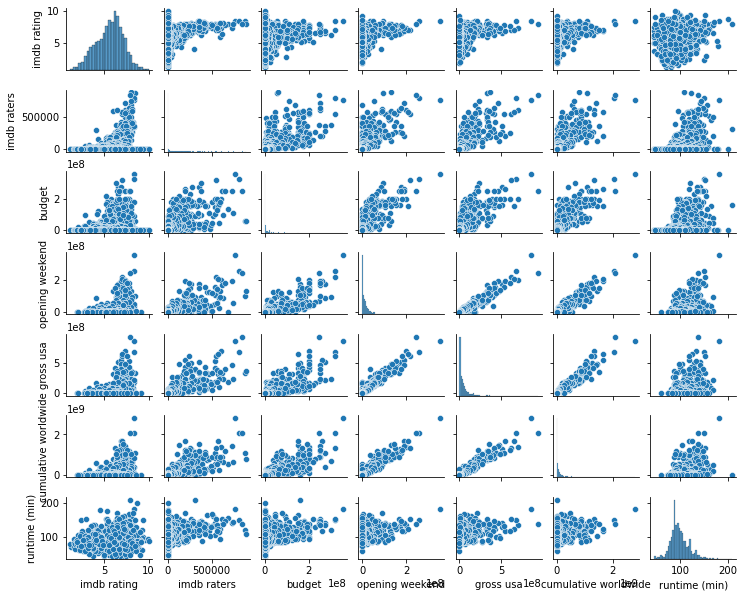

In [8]:
sns.pairplot(movies_df_drop, height=1.2, aspect=1.25);
# Visualize some relationships

### Let's start cleaning the data to try and get an MVP

Drop rows with no rating, no MPAA, no release date, and no runtime

In [9]:
movies_df_drop['mpaa'].fillna('Other', inplace=True)
# I don't want to lose titles with no MPAA, so let's fill in missing values with "Other"

In [11]:
movie_drop2 = movies_df_drop[movies_df_drop['imdb rating'].notna()]
# Drop movies without a rating

In [14]:
movie_drop2 = movie_drop2[movie_drop2['imdb raters'] >= 1000]
# Remove movies with less than 1,000 raters for better validity in ratings

In [15]:
movie_drop2 = movie_drop2[movie_drop2['budget'] >= 1000]
# Remove movies with less than a $1,000 budget to focus model

In [16]:
movie_drop2 = movie_drop2[movie_drop2['runtime (min)'].notna()]
# Removes movies without Runtime data

Test out the new DataFrame

In [17]:
X, y = movie_drop2[['runtime (min)']], movie_drop2['imdb rating']

In [18]:
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.22963261783249

Turned out small, but I think we can do better.<br>
Let's attempt to turn MPAA into dummy variables

In [19]:
mpaa_df = pd.get_dummies(movie_drop2['mpaa'])

In [20]:
df_added_mpaa_dummies = pd.concat([movie_drop2,mpaa_df], axis=1)

In [21]:
X, y = df_added_mpaa_dummies[['runtime (min)','G','R','PG','PG-13','Other']], df_added_mpaa_dummies['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.2568879017407165

Only slightly better with the MPAA data. <br>
Let's add in country and language dummy variables.

In [207]:
df_added_mpaa_dummies.head()

movie title  imdb rating  imdb raters   mpaa  \
0                          Tenet          7.8     123363.0  PG-13   
1                          Mulan          5.4      57966.0  PG-13   
2  I&#39;m Thinking of Ending Things          6.7      38680.0      R   
3              The Invisible Man          7.1     136012.0      R   
4      Bill &amp; Ted Face the Music          6.2      19157.0  PG-13   

                                genres           director             writer  \
0                     [Action, Sci-Fi]  Christopher Nolan  Christopher Nolan   
1   [Action, Adventure, Drama, Family]          Niki Caro         Rick Jaffa   
2                    [Drama, Thriller]    Charlie Kaufman    Charlie Kaufman   
3  [Horror, Mystery, Sci-Fi, Thriller]     Leigh Whannell     Leigh Whannell   
4   [Adventure, Comedy, Music, Sci-Fi]       Dean Parisot     Chris Matheson   

                                               stars country language  ...  \
0  [John David Washington, Robert Pattinson, Eliz...      UK  English  ...   
1                   [Yifei Liu, Donnie Yen, Li Gong]     USA  English  ...   
2     [Jesse Plemons, Jessie Buckley, Toni Collette]     USA  English  ...   
3  [Elisabeth Moss, Oliver Jackson-Cohen, Harriet...  Canada  English  ...   
4        [Keanu Reeves, Alex Winter, Kristen Schaal]     USA  English  ...   

        budget  opening weekend   gross usa  cumulative worldwide  \
0  205000000.0       20200000.0  41200000.0           284900000.0   
1  200000000.0              NaN         NaN            64400000.0   
2          NaN              NaN         NaN                   NaN   
3    7000000.0       28205665.0  64914050.0           130722137.0   
4          NaN        1125007.0   3305411.0             5099560.0   

                                production companies runtime (min)  G  PG  \
0                            [Warner Bros., Syncopy]         150.0  0   0   
1  [Walt Disney Pictures, Jason T. Reed Productio...         115.0  0   0   
2         [Likely Story, Projective Testing Service]         134.0  0   0   
3  [Universal Pictures, Blumhouse Productions, Go...         124.0  0   0   
4  [Hammerstone Studios, Dugan Entertainment, Man...          91.0  0   0   

   PG-13  R  
0      1  0  
1      1  0  
2      0  1  
3      0  1  
4      1  0  

[5 rows x 21 columns]

In [197]:
dummy_df = pd.get_dummies(data=movie_page_info_drop1,columns=['mpaa','country','language'])

In [198]:
dummy_df.drop(axis=1,labels=['imdb raters','stars','budget','opening weekend','gross usa','cumulative worldwide','production companies','genres','director','writer'],inplace=True)

In [199]:
dummy_df.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
Int64Index: 849 entries, 0 to 1987
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   movie title                      849 non-null    object 
 1   imdb rating                      849 non-null    float64
 2   release date                     849 non-null    object 
 3   runtime (min)                    849 non-null    float64
 4   mpaa_G                           849 non-null    uint8  
 5   mpaa_PG                          849 non-null    uint8  
 6   mpaa_PG-13                       849 non-null    uint8  
 7   mpaa_R                           849 non-null    uint8  
 8   country_Australia                849 non-null    uint8  
 9   country_Belgium                  849 non-null    uint8  
 10  country_Bulgaria                 849 non-null    uint8  
 11  country_Canada                   849 non-null    uint8  
 12  country

In [201]:
X, y = dummy_df.iloc[:,3:], dummy_df['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.2855735746861925

In [204]:
genres1 = pd.Series(movie_page_info_drop1['genres'])

In [205]:
pd.get_dummies(genres1.apply(pd.Series).stack()).sum(level=0)

Action  Adventure  Animation  Biography  Comedy  Crime  Drama  Family  \
0          1          0          0          0       0      0      0       0   
1          1          1          0          0       0      0      1       1   
2          0          0          0          0       0      0      1       0   
3          0          0          0          0       0      0      0       0   
4          0          1          0          0       1      0      0       0   
...      ...        ...        ...        ...     ...    ...    ...     ...   
1927       1          0          0          0       0      1      1       0   
1952       0          0          0          0       1      0      0       1   
1966       0          1          0          0       1      0      0       1   
1975       0          0          0          0       0      0      0       0   
1987       0          0          0          0       0      0      1       0   

      Fantasy  History  Horror  Music  Musical  Mystery  Romance  Sci-Fi  \
0           0        0       0      0        0        0        0       1   
1           0        0       0      0        0        0        0       0   
2           0        0       0      0        0        0        0       0   
3           0        0       1      0        0        1        0       1   
4           0        0       0      1        0        0        0       1   
...       ...      ...     ...    ...      ...      ...      ...     ...   
1927        0        0       0      0        0        0        0       0   
1952        0        0       0      0        0        0        0       0   
1966        1        0       0      0        0        0        0       1   
1975        0        0       1      0        0        0        0       0   
1987        0        0       0      0        0        0        0       1   

      Sport  Thriller  War  Western  
0         0         0    0        0  
1         0         0    0        0  
2         0         1    0        0  
3         0         1    0        0  
4         0         0    0        0  
...     ...       ...  ...      ...  
1927      0         1    0        0  
1952      0         0    0        0  
1966      0         0    0        0  
1975      0         0    0        0  
1987      0         1    0        0  

[849 rows x 20 columns]